In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy


from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США
- account_length — длительность использования аккаунта
- area_code — деление пользователей на псевдорегионы, использующееся в телекоме
- intl_plan — подключена ли у пользователя услуга международного общения
- vmail_plan — подключена ли у пользователя услуга голосовых сообщений
- vmail_message — количество голосых сообщений, который пользователь отправил / принял
- day_calls — сколько пользователь совершил дневных звонков
- day_mins — сколько пользователь проговорил минут в течение дня
- day_charge — сколько пользователь заплатил за свою дневную активность
- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
- custserv_calls — сколько раз пользователь позвонил в службу поддержки
- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
- mes_estim — оценка интенсивности пользования интернет мессенджерами
- churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [4]:
data = pd.read_csv('churn_analysis.csv',sep=',')
data

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3328,AZ,192,415,no,yes,36,156.2,77,26.55,...,279.1,83,12.56,9.9,6,2.67,2,2,0.59,False.
3329,3329,WV,68,415,no,no,0,231.1,57,39.29,...,191.3,123,8.61,9.6,4,2.59,3,2,0.32,False.
3330,3330,RI,28,510,no,no,0,180.8,109,30.74,...,191.9,91,8.64,14.1,6,3.81,2,1,0.47,False.
3331,3331,CT,184,510,yes,no,0,213.8,105,36.35,...,139.2,137,6.26,5.0,10,1.35,2,2,0.32,False.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3333 non-null   int64  
 1   state           3333 non-null   object 
 2   account_length  3333 non-null   int64  
 3   area_code       3333 non-null   int64  
 4   intl_plan       3333 non-null   object 
 5   vmail_plan      3333 non-null   object 
 6   vmail_message   3333 non-null   int64  
 7   day_mins        3333 non-null   float64
 8   day_calls       3333 non-null   int64  
 9   day_charge      3333 non-null   float64
 10  eve_mins        3333 non-null   float64
 11  eve_calls       3333 non-null   int64  
 12  eve_charge      3333 non-null   float64
 13  night_mins      3333 non-null   float64
 14  night_calls     3333 non-null   int64  
 15  night_charge    3333 non-null   float64
 16  intl_mins       3333 non-null   float64
 17  intl_calls      3333 non-null   i

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции scipy.stats.chi2_contingency(subtable, correction=False)

Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем \alpha=0.05α=0.05?

In [11]:
state_churn = pd.pivot_table(data[data['treatment'] == 1], values='treatment', index='state',
                     columns='churn', aggfunc=len, fill_value = 0)
state_churn.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [20]:
chi2_val = pd.DataFrame(columns=['state 1', 'state 2', 'chi_2', 'p-value'])

In [16]:
from itertools import combinations

In [21]:
i = 0 
for st1, st2 in combinations(state_churn.index,2):
    chi2_table = state_churn.loc[[st1, st2],:]
    chi2_val.loc[i, 'state 1'] = st1
    chi2_val.loc[i, 'state 2'] = st2
    chi2_stat = stats.chi2_contingency(chi2_table.values, correction=False)
    chi2_val.loc[i, 'chi_2'] = chi2_stat[0]
    chi2_val.loc[i, 'p-value'] = chi2_stat[1]
    i += 1
chi2_val

,state 1,state 2,chi_2,p-value
0,AK,AL,1.54672,0.213621
1,AK,AR,4.41,0.0357288
2,AK,AZ,0.419079,0.517397
3,AK,CA,4.84435,0.0277369
4,AK,CO,2.68864,0.101066
...,...,...,...,...
1270,WA,WV,1.72063,0.189612
1271,WA,WY,3.20158,0.0735671
1272,WI,WV,0.666667,0.414216
1273,WI,WY,0.00829726,0.927422


In [22]:
len(chi2_val[chi2_val['p-value'] < 0.05])

34

In [23]:
i = 0 
for st1, st2 in combinations(state_churn.index,2):
    chi2_table = state_churn.loc[[st1, st2],:]
    chi2_val.loc[i, 'state 1'] = st1
    chi2_val.loc[i, 'state 2'] = st2
    chi2_stat = stats.chi2_contingency(chi2_table.values, correction=True)
    chi2_val.loc[i, 'chi_2'] = chi2_stat[0]
    chi2_val.loc[i, 'p-value'] = chi2_stat[1]
    i += 1
chi2_val

,state 1,state 2,chi_2,p-value
0,AK,AL,0.639205,0.423999
1,AK,AR,2.7225,0.0989429
2,AK,AZ,0.00213816,0.963119
3,AK,CA,3.05496,0.0804911
4,AK,CO,1.4358,0.230821
...,...,...,...,...
1270,WA,WV,0.961945,0.326697
1271,WA,WY,2.00655,0.156622
1272,WI,WV,0.166667,0.683091
1273,WI,WY,0.187207,0.665252


In [24]:
len(chi2_val[chi2_val['p-value'] < 0.05])

0

In [26]:
fisher_val = pd.DataFrame(columns=['state 1', 'state 2', 'fisher_stat', 'p-value'])
i = 0
for st1, st2 in combinations(state_churn.index, 2):
    fisher_table = state_churn.loc[[st1, st2],:]
    fisher_val.loc[i, 'state 1'] = st1
    fisher_val.loc[i, 'state 2'] = st2
    fisher_stat = stats.fisher_exact(fisher_table.values)
    fisher_val.loc[i, 'fisher_stat'] = fisher_stat[0]
    fisher_val.loc[i, 'p-value'] = fisher_stat[1]
    i += 1

In [27]:
fisher_val

,state 1,state 2,fisher_stat,p-value
0,AK,AL,3.8,0.381063
1,AK,AR,8.63636,0.0688616
2,AK,AZ,2.23529,0.60499
3,AK,CA,9.5,0.0639647
4,AK,CO,5.58824,0.187034
...,...,...,...,...
1270,WA,WV,0.42328,0.207829
1271,WA,WY,0.228571,0.134552
1272,WI,WV,2.03704,0.686168
1273,WI,WY,1.1,1


In [28]:
print('Pearson correlation: %.4f' % stats.pearsonr(data.day_calls, data.mes_estim)[0])
print('P-value: %.4f' % stats.pearsonr(data.day_calls, data.mes_estim)[1])

Pearson correlation: -0.0518
P-value: 0.0028


In [29]:
print('Spearman correlation: %.4f' % stats.spearmanr(data.day_calls, data.mes_estim)[0])
print('P-value: %.4f' % stats.spearmanr(data.day_calls, data.mes_estim)[1])

Spearman correlation: 0.0433
P-value: 0.0123


((array([-3.5297919 , -3.28786833, -3.15418238, ...,  3.15418238,
          3.28786833,  3.5297919 ]),
  array([0.05, 0.05, 0.05, ..., 0.89, 0.91, 0.96])),
 (0.13861708020693375, 0.4842364236423642, 0.9996050483985336))

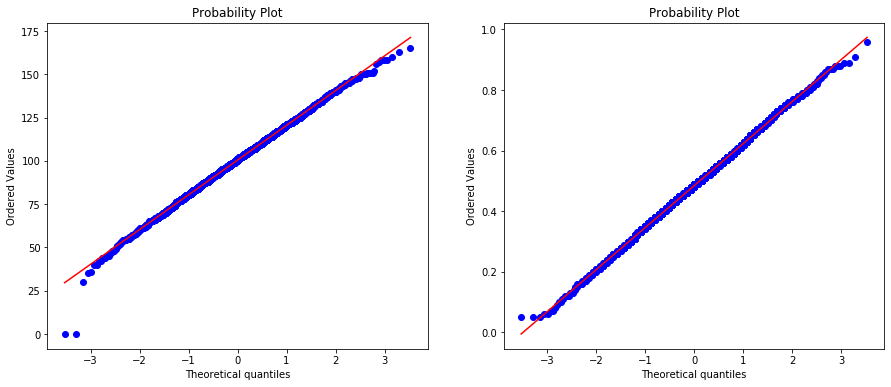

In [32]:
plt.figure(figsize=(15,6))
plt.subplot(121)
stats.probplot(data.day_calls, dist="norm", plot=plt)
plt.subplot(122)
stats.probplot(data.mes_estim, dist="norm", plot=plt)

In [33]:

def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [34]:
print('V Cramer stat value: %.4f' % cramers_stat(state_churn.values))
print('p-value: %.4f' % stats.chi2_contingency(state_churn.values)[1])

V Cramer stat value: 0.2004
p-value: 0.7098


In [36]:

pt_states = pd.pivot_table(data, values='account_length', index='state', columns=['treatment', 'churn'],
                               aggfunc=len, fill_value=0)
pt_states

treatment      0            1            2      
churn     False. True. False. True. False. True.
state                                           
AK            15     2     19     1     15     0
AL            22     1     25     5     25     2
AR            14     3     11     5     19     3
AZ            26     0     17     2     17     2
CA            10     3     10     5      5     1
CO            20     2     17     5     20     2
CT            22     3     25     5     15     4
DC            19     3     18     1     12     1
DE            18     4     16     1     18     4
FL            16     4     18     2     21     2
GA            11     5     19     2     16     1
HI            17     1     12     1     21     1
IA            13     1     13     2     15     0
ID            22     6     16     2     26     1
IL            25     2     11     1     17     2
IN            22     4     20     3     20     2
KS            21     2     18     7     18     4
KY            18     2     21     4     12     2
LA            11     1     15     0     21     3
MA            20     2     17     7     17     2
MD            11     6     19     5     23     6
ME            14     4     20     8     15     1
MI            22     6     17     5     18     5
MN            28     6     19     2     22     7
MO            22     1     17     4     17     2
MS            15     9     20     4     16     1
MT            19     6     22     4     13     4
NC            21     4     16     3     20     4
ND            17     2     21     3     18     1
NE            16     1     21     3     19     1
NH            20     3     10     2     17     4
NJ            12     7     20     4     18     7
NM            14     3     27     2     15     1
NV            11     3     18     6     23     5
NY            22     4     27     6     19     5
OH            25     3     22     2     21     5
OK            19     1     11     2     22     6
OR            18     7     18     3     31     1
PA            13     3     14     4     10     1
RI            15     1     18     4     26     1
SC            15     3     16     5     15     6
SD            19     2     20     3     13     3
TN            18     1     11     1     19     3
TX            26     7     14     6     14     5
UT            23     4     18     4     21     2
VA            22     2     20     3     30     0
VT            24     1     18     5     23     2
WA            20     4     16     7     16     3
WI            25     4     22     2     24     1
WV            37     2     27     5     32     3
WY            23     4     20     2     25     3

In [38]:
props_churn = np.array([pt_states.loc[:, treat].loc[:, True].sum() /(pt_states.loc[:, treat].loc[:, False].sum() + pt_states.loc[:, treat].loc[:, True].sum())
                        for treat in range(3)])
for i, prop in enumerate(props_churn):
    print('Treatment #%d prop. of churn = 1: %.4f' % (i, prop))

KeyError: True